# Regression discontinuity with sci-kit learn models

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel

import causalpy as cp

In [2]:
%config InlineBackend.figure_format = 'retina'

## Load data

In [3]:
data = cp.load_data("rd")
data.head()

,x,y,treated
0,-0.932739,-0.091919,False
1,-0.930778,-0.382663,False
2,-0.929110,-0.181786,False
3,-0.907419,-0.288245,False
4,-0.882469,-0.420811,False


## Linear, main-effects model

In [4]:
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated",
    model=cp.skl_models.LinearRegression(),
    treatment_threshold=0.5,
)

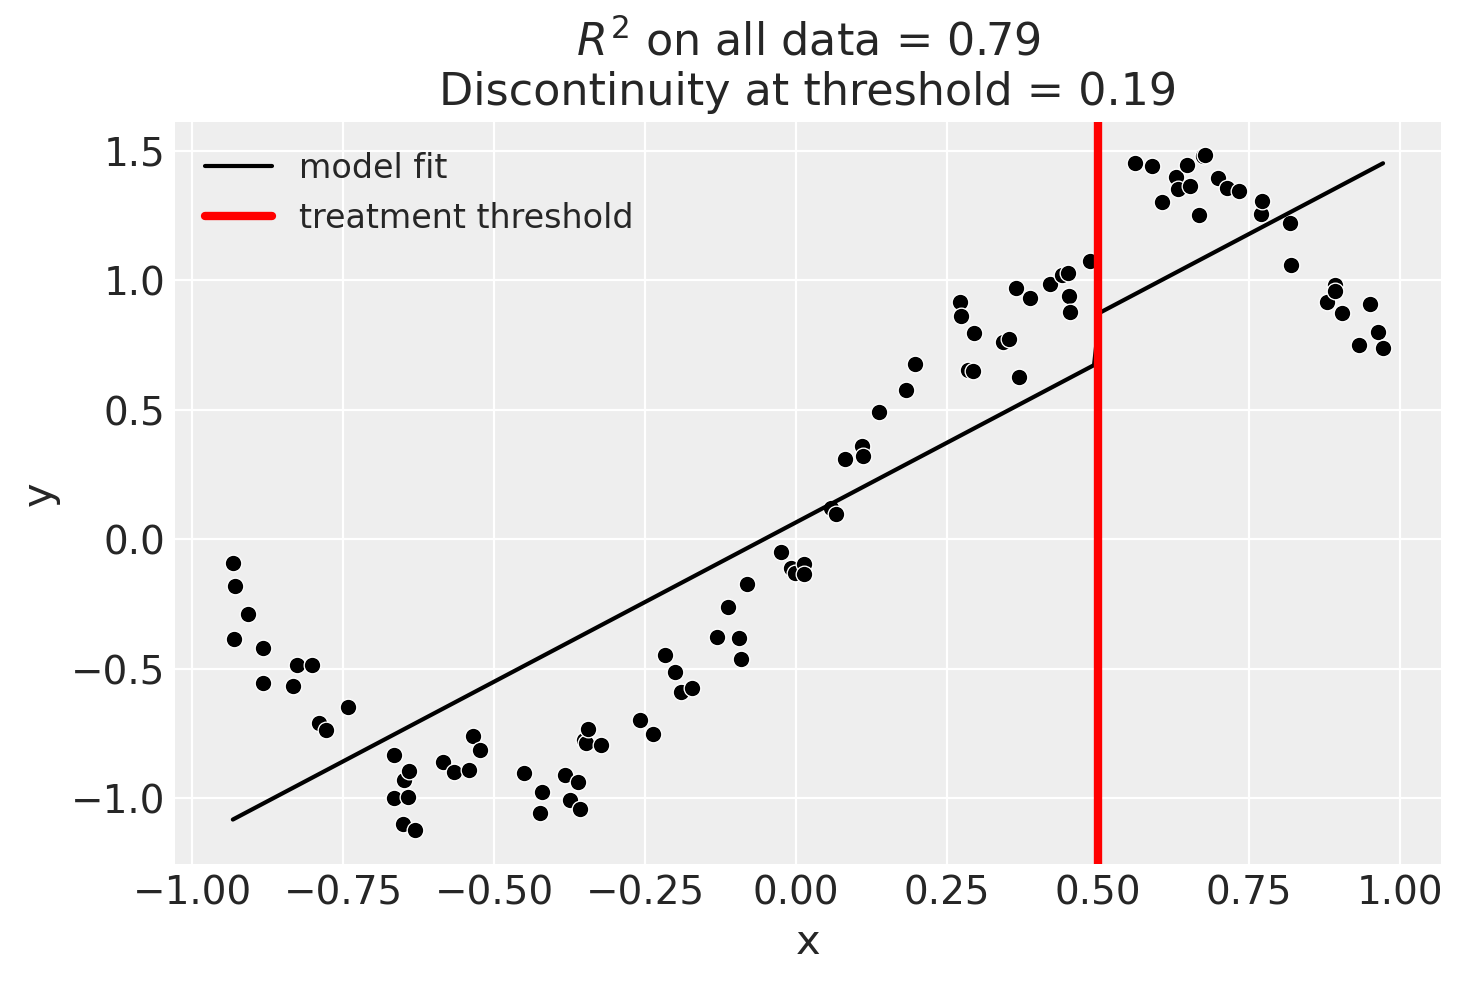

In [6]:
fig, ax = result.plot()

In [7]:
result.summary(round_to=3)

Difference in Differences experiment
Formula: y ~ 1 + x + treated
Running variable: x
Threshold on running variable: 0.5

Results:
Discontinuity at threshold = 0.19


Model coefficients:
  Intercept      	         0
  treated[T.True]	      0.19
  x              	      1.23


## Linear, main-effects, and interaction model

In [8]:
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.skl_models.LinearRegression(),
    treatment_threshold=0.5,
)

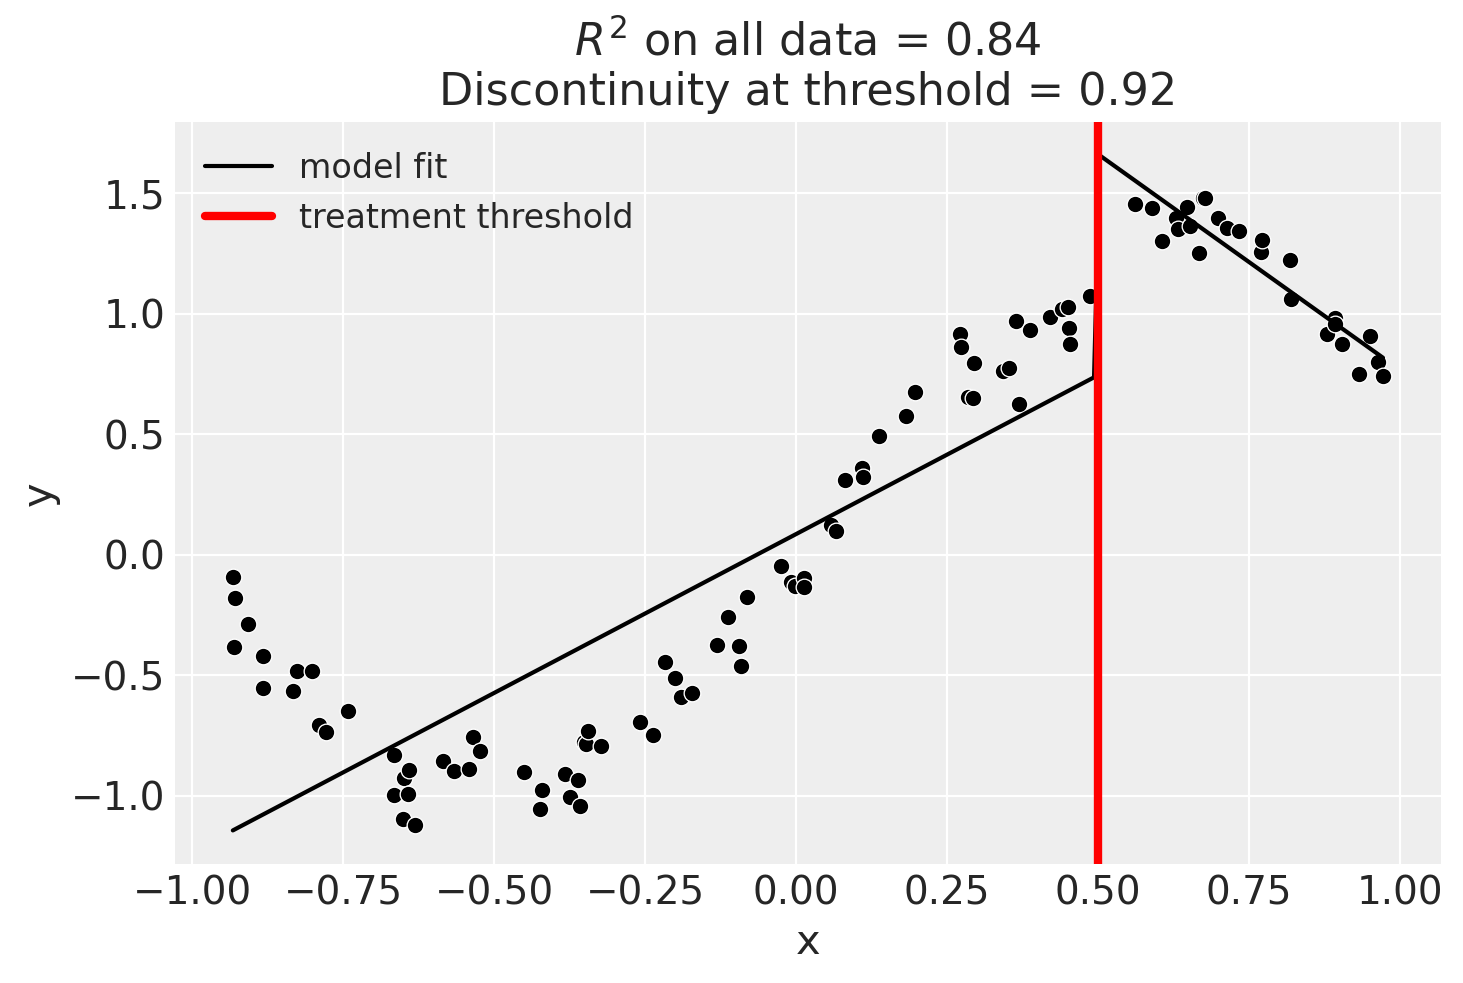

In [9]:
result.plot();

Though we can see that this does not give a good fit of the data almost certainly overestimates the discontinuity at threshold.

In [10]:
result.summary(round_to=3)

Difference in Differences experiment
Formula: y ~ 1 + x + treated + x:treated
Running variable: x
Threshold on running variable: 0.5

Results:
Discontinuity at threshold = 0.92


Model coefficients:
  Intercept        	         0
  treated[T.True]  	      2.47
  x                	      1.32
  x:treated[T.True]	     -3.11


## Using a bandwidth

One way how we could deal with this is to use the `bandwidth` kwarg. This will only fit the model to data within a certain bandwidth of the threshold. If $x$ is the running variable, then the model will only be fitted to data where $threshold - bandwidth \le x \le threshold + bandwidth$.

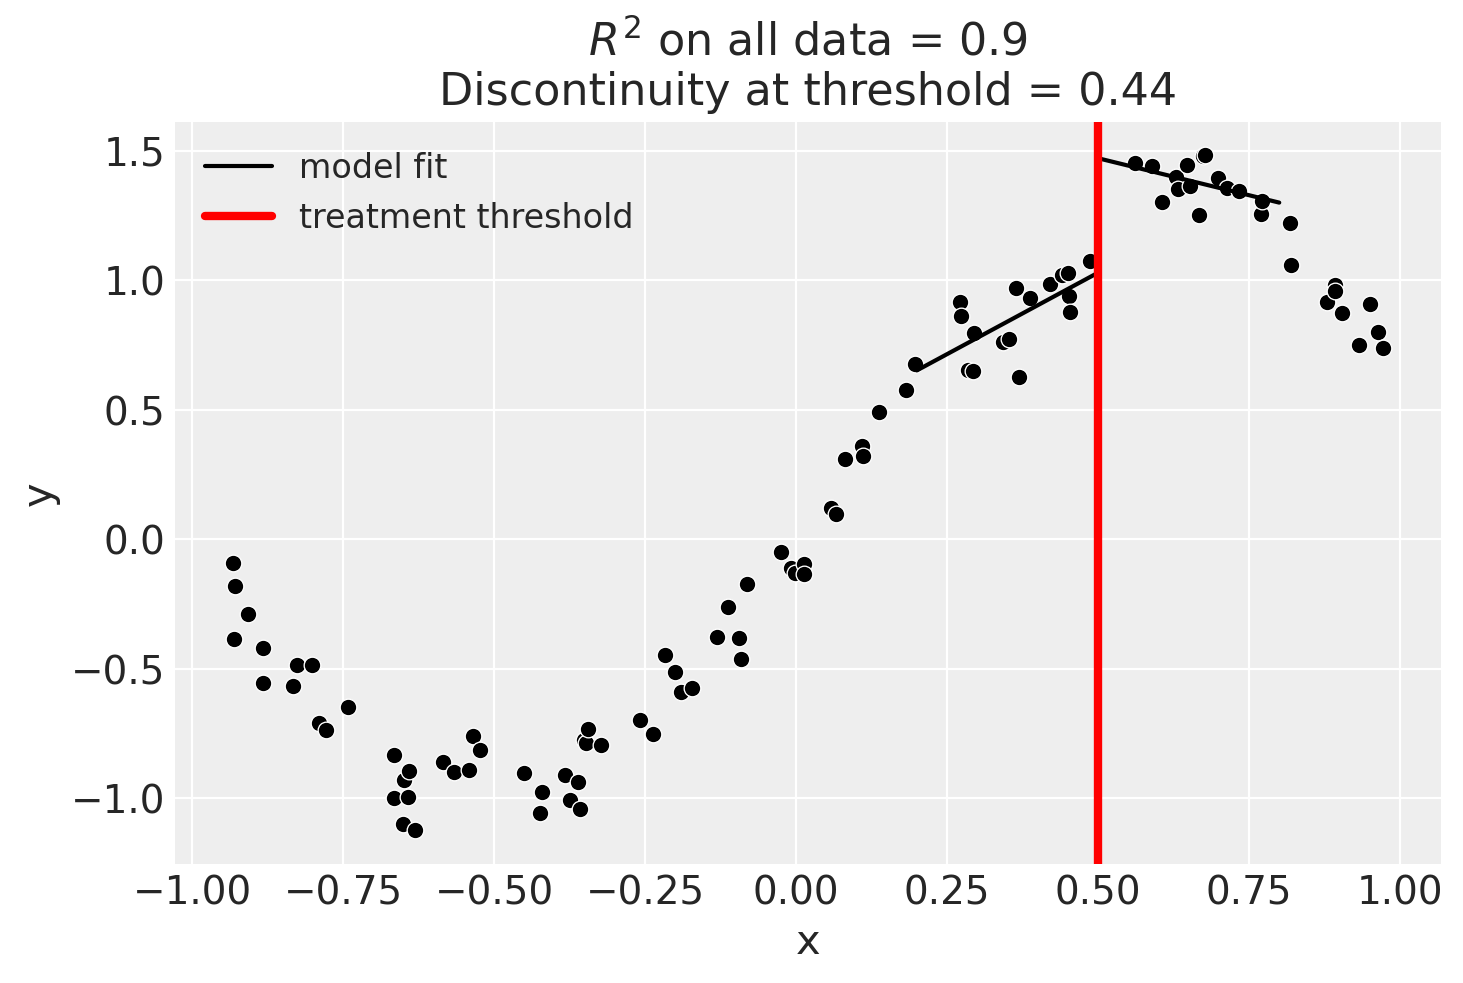

In [11]:
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.skl_models.LinearRegression(),
    treatment_threshold=0.5,
    bandwidth=0.3,
)

result.plot();

We could even go crazy and just fit intercepts for the data close to the threshold. But clearly this will involve more estimation error as we are using less data.

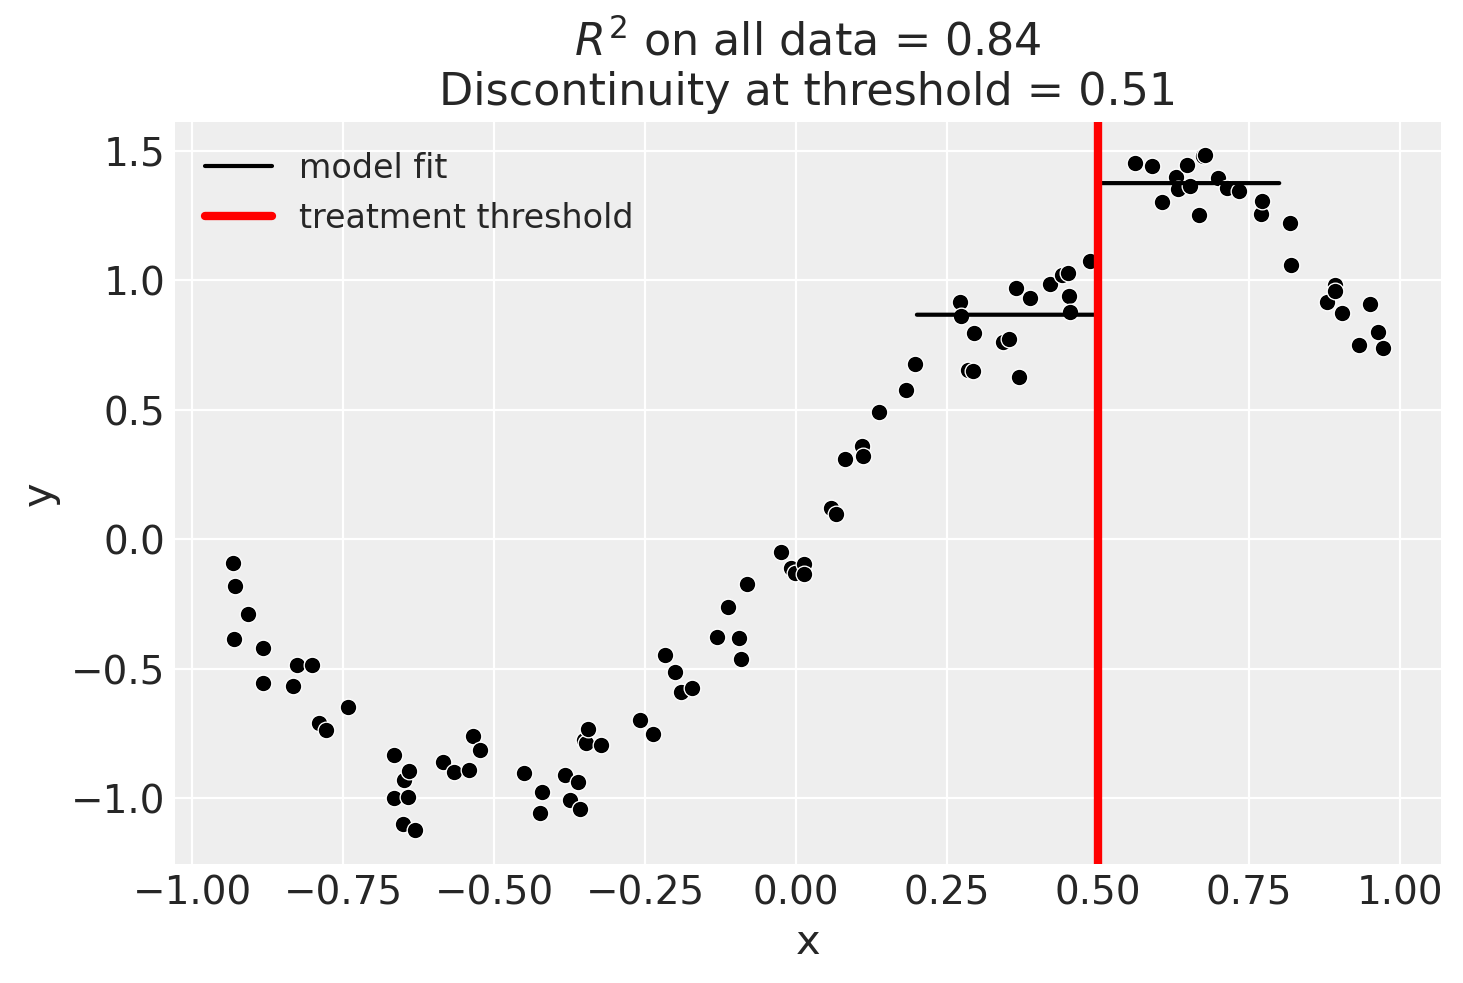

In [12]:
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + treated",
    model=cp.skl_models.LinearRegression(),
    treatment_threshold=0.5,
    bandwidth=0.3,
)

result.plot();

## Using Gaussian Processes

In [13]:
kernel = 1.0 * ExpSineSquared(1.0, 5.0) + WhiteKernel(1e-1)
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + x + treated",
    model=GaussianProcessRegressor(kernel=kernel),
    treatment_threshold=0.5,
)

In [14]:
fig, ax = result.plot()

AttributeError: 'GaussianProcessRegressor' object has no attribute 'get_plot_component'

## Using basis splines

In [15]:
result = cp.RegressionDiscontinuity(
    data,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=cp.skl_models.LinearRegression(),
    treatment_threshold=0.5,
)

TypeError: cannot unpack non-iterable NoneType object

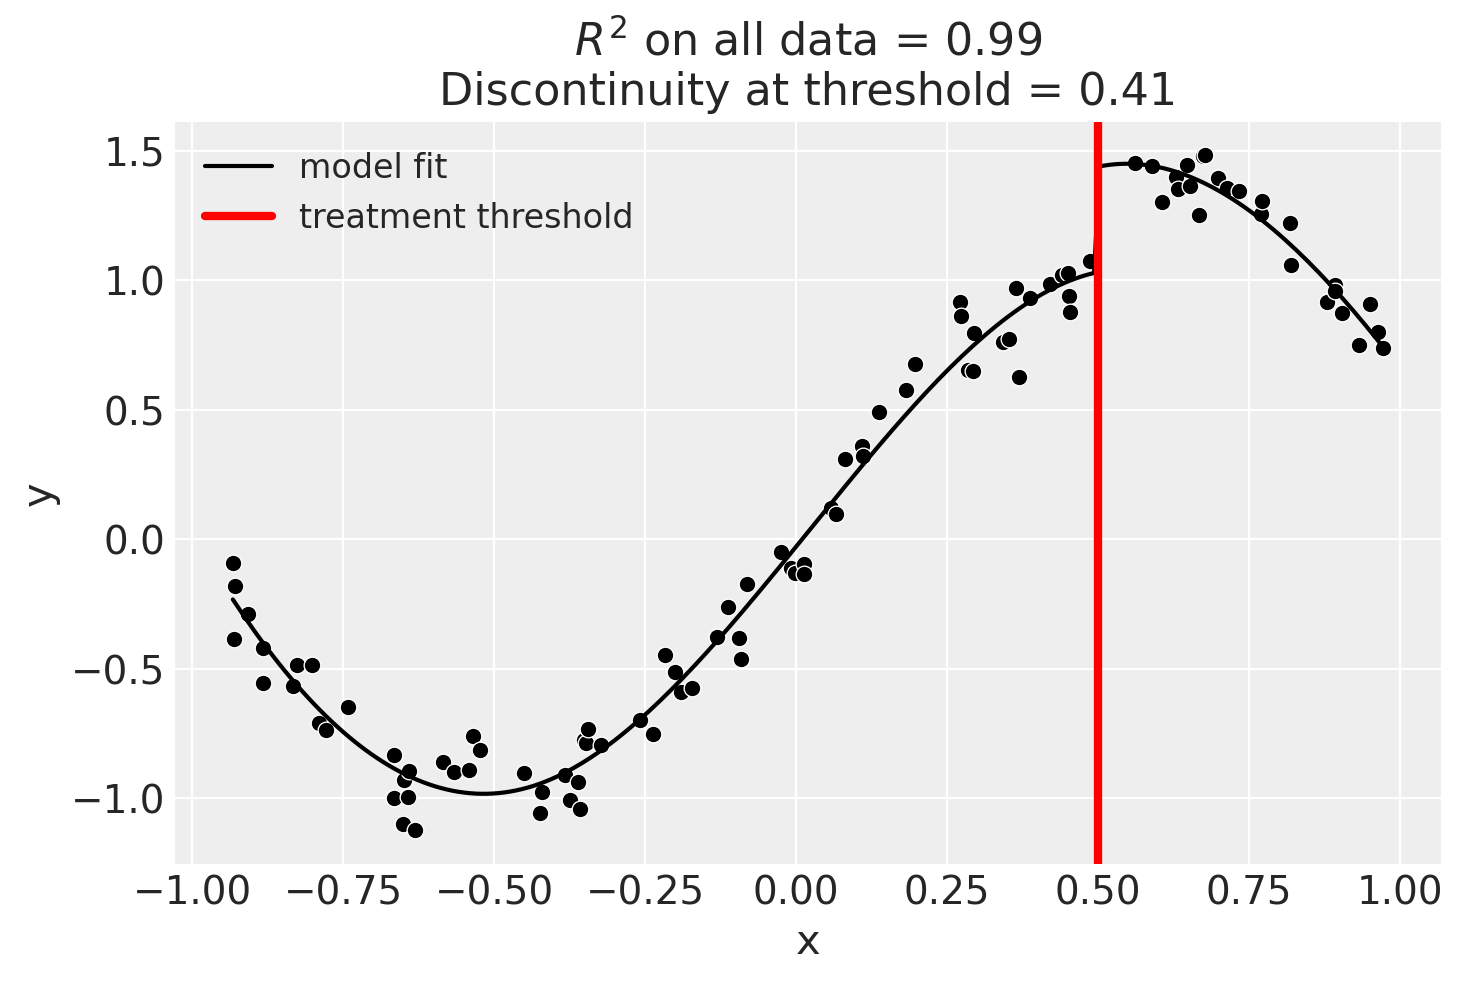

In [16]:
fig, ax = result.plot()

In [17]:
result.summary(round_to=3)

Difference in Differences experiment
Formula: y ~ 1 + bs(x, df=6) + treated
Running variable: x
Threshold on running variable: 0.5

Results:
Discontinuity at threshold = 0.41


Model coefficients:
  Intercept      	         0
  treated[T.True]	     0.407
  bs(x, df=6)[0] 	    -0.594
  bs(x, df=6)[1] 	     -1.07
  bs(x, df=6)[2] 	     0.278
  bs(x, df=6)[3] 	      1.65
  bs(x, df=6)[4] 	      1.03
  bs(x, df=6)[5] 	     0.567
